In [6]:
# import stuff

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('C:\\Users\\nicol\\Desktop\\pythonfiles\\micrometereology\\03')

from scipy.fft import rfft, rfftfreq, fft, fftfreq, ifft, irfft
import scipy.integrate as integrate


In [7]:
# FUNCTIONS

def plt_format_question1c(data_name):
    plt.rc('font', size=12)
    plt.rc('axes', titlesize=14)
    plt.rc('axes', labelsize=14)
    plt.xlabel('frequency [1/s]')
    plt.ylabel('S(f) [m^2/s]')
    plt.legend(loc='lower left')
    plt.title(f"Spectrum for {data_name} component")

    plt.yscale("log")
    plt.xscale("log")

    plt.xlim(10**-4, 50)


def plt_format_question1d(data_name):
    plt.rc('font', size=12)
    plt.rc('axes', titlesize=14)
    plt.rc('axes', labelsize=14)
    plt.xlabel('frequency [1/s]')
    plt.ylabel('f * S(f) [m^2/s^2]')
    plt.legend(loc='lower left')
    plt.title(f"Spectrum for {data_name} component")

    plt.yscale("log")
    plt.xscale("log")

    #plt.xlim(10**-4, 50)

def plt_format_question1d_comparison():
    plt.rc('font', size=12)
    plt.rc('axes', titlesize=14)
    plt.rc('axes', labelsize=14)
    plt.xlabel('frequency [1/s]')
    plt.ylabel('f * S(f) [m^2/s^2]')
    plt.legend(loc='upper right')
    plt.title(f"Averaged spectrum for all components")

    plt.yscale("log")
    plt.xscale("log")

    

def check_compliant(x_array,limit):
    counter = 0
    array_name = [name for name, value in globals().items() if value is x_array][0]
    for i in range(len(x_array)):
        if x_array[i] > limit:
            print(f"value of {x_array[i]:.2f} at line {i:.0f}")
            counter = counter + 1
    print(f"for {array_name} a total of {counter} elements are above {limit:.2f}")


def compute_rfftfreq(x_array, N_tot, K, fs):

    deltat = 1/fs
    N = int(N_tot/K)
    
    part_length = len(x_array) // K
    x_array_parts = [x_array[i * part_length:(i + 1) * part_length] for i in range(K)]

    y_tot = []
    for array in x_array_parts:
        y = rfft(array)
        x = rfftfreq(N, deltat)
        S_y = 1/(N*fs)*np.abs(y)**2
        y_tot.append(S_y)

    y_mean = np.mean(y_tot, axis=0)
    return x[1:], y_mean[1:]


def compute_omega_S1(x_array, y_array, original_array, variance):

    fS = x_array*y_array

    integral = integrate.trapezoid(y=fS,x=np.log(x_array))
    variance2 = 2*integral
    
    if variance == True:
        original_name = [name for name, value in globals().items() if value is original_array][0]
        varriance1 = np.var(original_array)
        print(f"variances of {original_name} = {varriance1:.8f}, computed with trapezoid = {variance2:.8f}")
    
    return fS


def smoothering_filter(x_array, y_array, num):
    x_array = np.array(x_array)
    y_array = np.array(y_array)

    x_result = []
    y_result = []

    l = int(np.floor(np.log10(x_array[0])))
    u = int(np.ceil(np.log10(x_array[-1])))

    # Loop through orders of magnitude
    for order in range(l, u):
        lower_bound = 10 ** order
        upper_bound = 10 ** (order + 1)
        mask = (x_array >= lower_bound) & (x_array < upper_bound)

        # Split data into subsets for the current order of magnitude
        x_subset = x_array[mask]
        y_subset = y_array[mask]

        if len(x_subset) < num:
            x_avg = x_subset
            y_avg = y_subset
        else:
            # Split the data into num subsets
            x_subsets = np.array_split(x_subset, num)
            y_subsets = np.array_split(y_subset, num)

            # Calculate the average of each subset
            x_avg = [np.mean(subset) for subset in x_subsets]
            y_avg = [np.mean(subset) for subset in y_subsets]

        # Append the results to x_result and y_result
        x_result.extend(x_avg)
        y_result.extend(y_avg)

    return x_result, y_result

def linear_regression_loglog(x_array,y_array, start, stop):
    x_array = np.array(x_array)
    y_array = np.array(y_array)

    mask = (x_array >= start) & (x_array <= stop)
    x = x_array[mask]
    y = y_array[mask]

    x = np.log(x)
    y = np.log(y)

    x_ave = np.sum(x)/len(x)
    y_ave = np.sum(y)/len(y)
    squaresumx = np.sum((x-x_ave)**2)
    squaresumy = np.sum((y-y_ave)**2)
    crossterm = np.sum((x-x_ave)*(y-y_ave))
    slope = crossterm/squaresumx
    intercept = y_ave - slope*x_ave

    y_interpol = x * slope + intercept
    x_result = np.exp(x)
    y_result = np.exp(y_interpol)

    return slope, intercept, x_result, y_result


def power_law(slope, intercept, start, stop):
    x = np.linspace(start, stop, num=100)
    x = np.log(x)
    y = intercept + slope*x

    x_result = np.exp(x)
    y_result = np.exp(y)

    return x_result, y_result

def compute_ratios(x_array, Su, Sv, Sw, start, stop):
    x_array = np.array(x_array)
    Su = np.array(Su)
    Sv = np.array(Sv)
    Sw = np.array(Sw)

    mask = (x_array >= start) & (x_array <= stop)
    
    x = x_array[mask]
    Su_i = Su[mask]
    Sv_i = Sv[mask]
    Sw_i = Sw[mask]

    alpha1_array = Sv_i/Su_i
    alpha2_array = Sw_i/Su_i

    alpha1 = np.mean(alpha1_array)
    alpha2 = np.mean(alpha2_array)

    return alpha1, alpha2, Sv/Su, Sw/Su


def champions(x_array, y_array):
    x_array = np.array(x_array)
    y_array = np.array(np.log(y_array))
    sorted_indices = np.argsort(y_array)[::-1]

    # Get the first 5 y values and their corresponding x values
    top_5_y = y_array[sorted_indices[:5]]
    top_5_x = x_array[sorted_indices[:5]]

    day = 3600*24

    for i in range(len(top_5_y)):
        print(f'in position {i}: spectrum value = {top_5_y[i]:.2f} for f = {top_5_x[i]:.10f} Hz hence T = {1/top_5_x[i]/day:.2f} days')




In [8]:
# HOEVSOERE DATA
# 1 hour of data sampled at 20 Hz. the three columns are {u, v, w}

data = pd.read_csv('hoevsoere1hr_uvw.csv', delimiter=',', header=None, 
                    names=['u','v','w'])
fs = 20

u_array = data['u'].values
v_array = data['v'].values
w_array = data['w'].values

N_tot = len(u_array)


#check_compliant(u_array, 20)


In [9]:
# QUESTION 1a

u_mean = np.mean(u_array)
u_var = np.var(u_array)
print(f"for u: mean = {u_mean:.2f} m/s, var = {u_var:.1f} m/s")
v_mean = np.mean(v_array)
v_var = np.var(v_array)
print(f"for v: mean = {v_mean:.2f} m/s, var = {v_var:.2f} m/s")

w_mean = np.mean(w_array)
w_var = np.var(w_array)
print(f"for w: mean = {w_mean:.2f} m/s, var = {w_var:.2f} m/s")


for u: mean = 13.15 m/s, var = 1.9 m/s
for v: mean = -0.00 m/s, var = 0.73 m/s
for w: mean = 0.00 m/s, var = 0.39 m/s


In [10]:
# QUESTION 1b

u_array_nomean = u_array - u_mean
u_star_nomean = np.sqrt(-np.mean(u_array_nomean*w_array))
u_star = np.sqrt(-np.mean(u_array*w_array))


print('u_star        ', u_star)
print('u_star no mean', u_star_nomean)

u_star         0.5290091458484733
u_star no mean 0.533584121887821


variances of u2 = 1.89400824, computed with trapezoid = 1.52291671
variances of u_array = 1.89400824, computed with trapezoid = 1.52291671


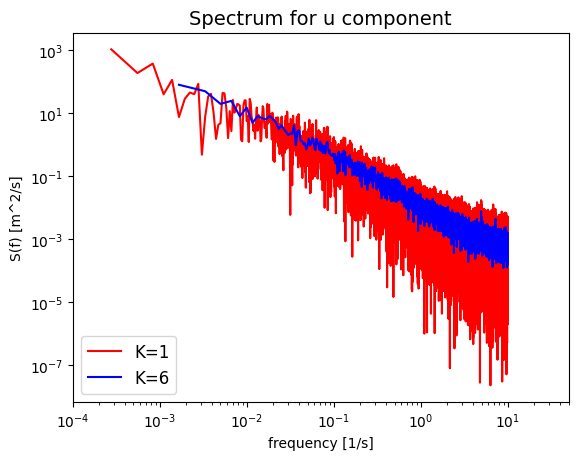

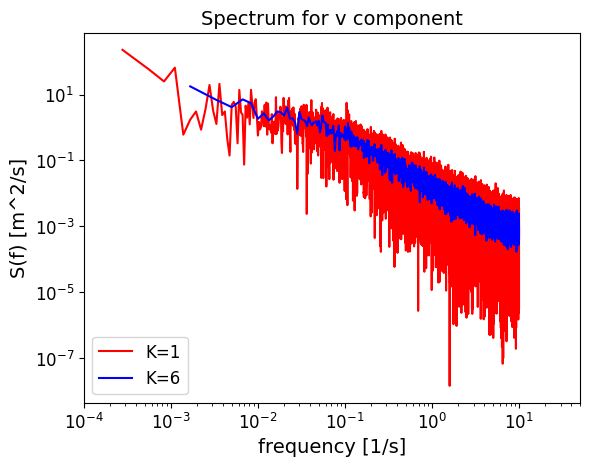

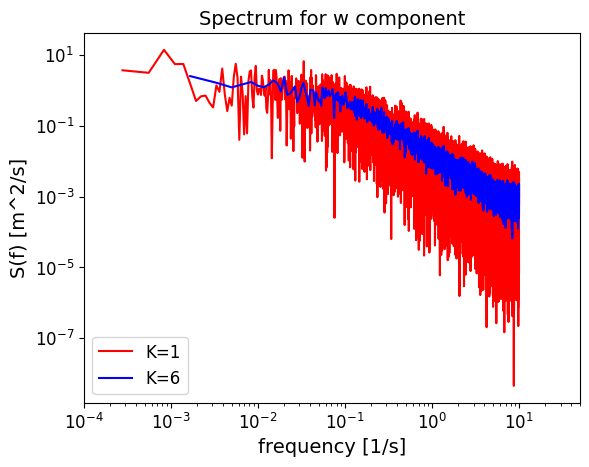

In [11]:
# QUESTION 1c
# check multiplication factor 2 pi
# plus or minus mean does not change


x1_u, y1_u = compute_rfftfreq(x_array=u_array, N_tot=N_tot, K=1, fs=fs)
x6_u, y6_u = compute_rfftfreq(x_array=u_array, N_tot=N_tot, K=6, fs=fs)

x2_u, y2_u = compute_rfftfreq(x_array=u_array-u_mean, N_tot=N_tot, K=1, fs=fs)


plt.figure(1)
plt.plot(x1_u, y1_u, color='r', label='K=1')
plt.plot(x6_u, y6_u, color='b', label='K=6')
plt_format_question1c('u')


x1_v, y1_v = compute_rfftfreq(x_array=v_array, N_tot=N_tot, K=1, fs=fs)
x6_v, y6_v = compute_rfftfreq(x_array=v_array, N_tot=N_tot, K=6, fs=fs)

plt.figure(2)
plt.plot(x1_v, y1_v, color='r', label='K=1')
plt.plot(x6_v, y6_v, color='b', label='K=6')
plt_format_question1c('v')


x1_w, y1_w = compute_rfftfreq(x_array=w_array, N_tot=N_tot, K=1, fs=fs)
x6_w, y6_w = compute_rfftfreq(x_array=w_array, N_tot=N_tot, K=6, fs=fs)

plt.figure(3)
plt.plot(x1_w, y1_w, color='r', label='K=1')
plt.plot(x6_w, y6_w, color='b', label='K=6')
plt_format_question1c('w')

u2 = u_array - u_mean
fS_u = compute_omega_S1(x_array=x1_u, y_array=y1_u, original_array=u2, variance=True)
fS_u = compute_omega_S1(x_array=x1_u, y_array=y1_u, original_array=u_array, variance=True)




len original 72000
len frequency 36000


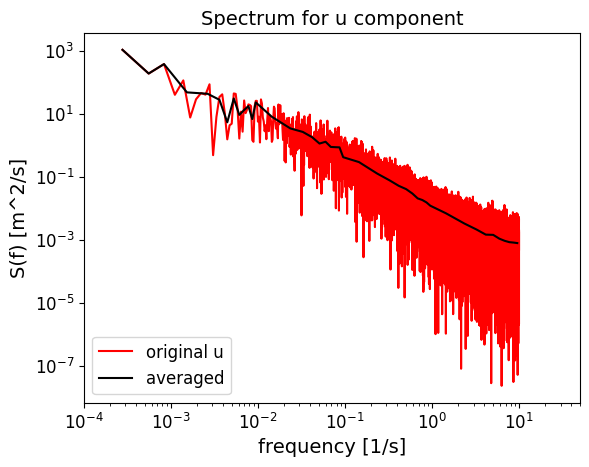

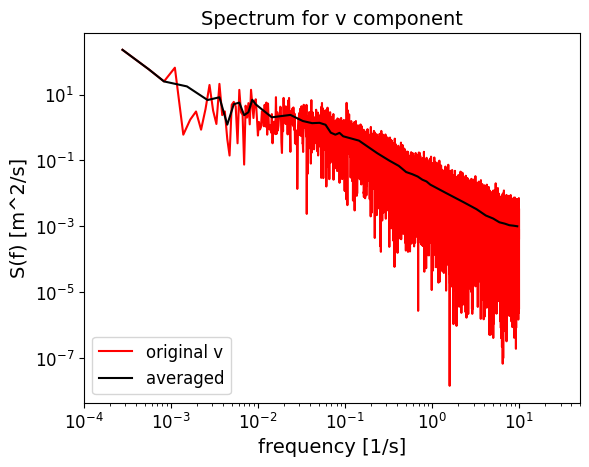

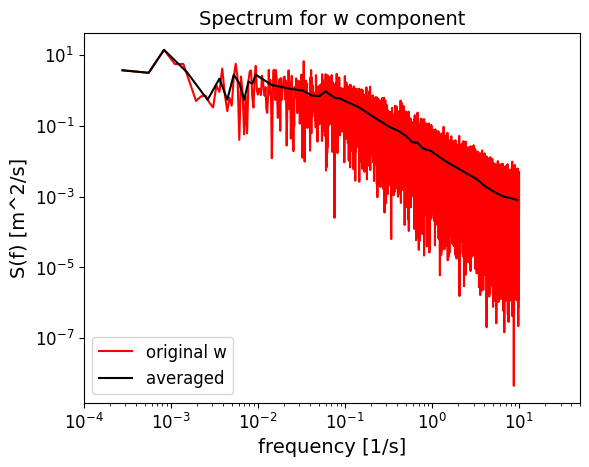

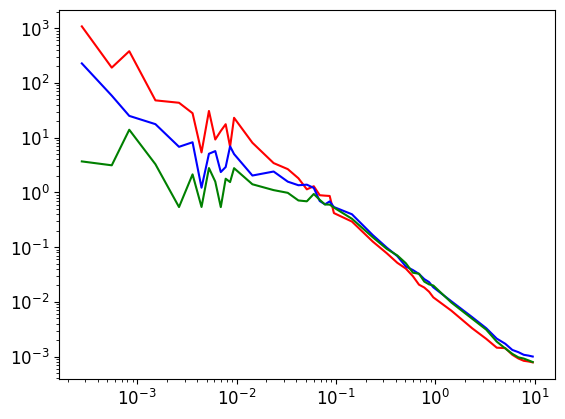

In [12]:
# QUESTION 1d version 1


x1_u, y1_u = compute_rfftfreq(x_array=u_array, N_tot=N_tot, K=1, fs=fs)
smoothx1_u, smoothy1_u = smoothering_filter(x_array=x1_u, y_array=y1_u, num=10)

print('len original', len(u_array))
print('len frequency', len(x1_u))


x1_v, y1_v = compute_rfftfreq(x_array=v_array, N_tot=N_tot, K=1, fs=fs)
smoothx1_v, smoothy1_v = smoothering_filter(x_array=x1_v, y_array=y1_v, num=10)

x1_w, y1_w = compute_rfftfreq(x_array=w_array, N_tot=N_tot, K=1, fs=fs)
smoothx1_w, smoothy1_w = smoothering_filter(x_array=x1_w, y_array=y1_w, num=10)


plt.figure(1)
plt.plot(x1_u, y1_u, color='r', label='original u')
plt.plot(smoothx1_u, smoothy1_u, color='k', label='averaged')
plt_format_question1c('u')


plt.figure(2)
plt.plot(x1_v, y1_v, color='r', label='original v')
plt.plot(smoothx1_v, smoothy1_v, color='k', label='averaged')
plt_format_question1c('v')


plt.figure(3)
plt.plot(x1_w, y1_w, color='r', label='original w')
plt.plot(smoothx1_w, smoothy1_w, color='k', label='averaged')
plt_format_question1c('w')


plt.figure(4)
plt.plot(smoothx1_u, smoothy1_u, color='r', label='u')
plt.plot(smoothx1_v, smoothy1_v, color='b', label='v')
plt.plot(smoothx1_w, smoothy1_w, color='g', label='w')

plt.xscale('log')
plt.yscale('log')

plt.show()


variances of u_array = 1.89400824, computed with trapezoid = 1.52291671
variances of v_array = 0.73191460, computed with trapezoid = 0.65398285
variances of w_array = 0.38810437, computed with trapezoid = 0.38739245


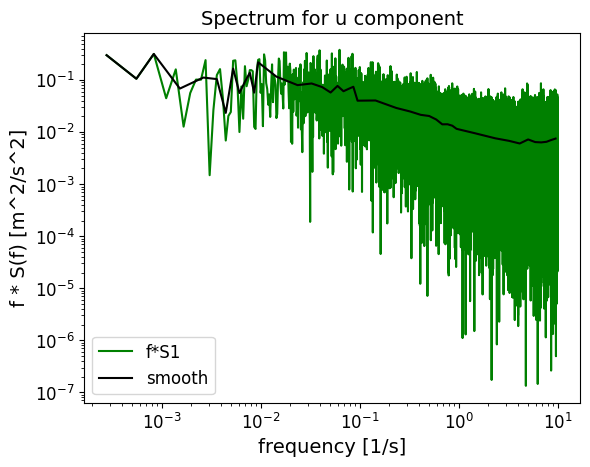

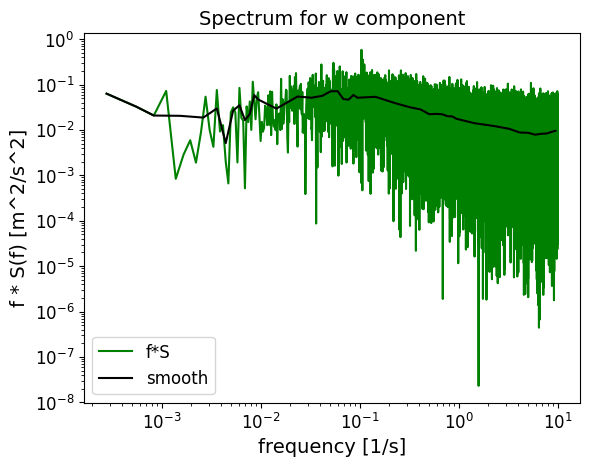

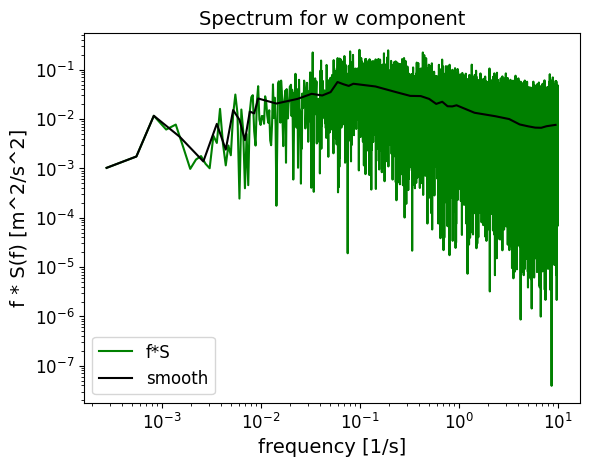

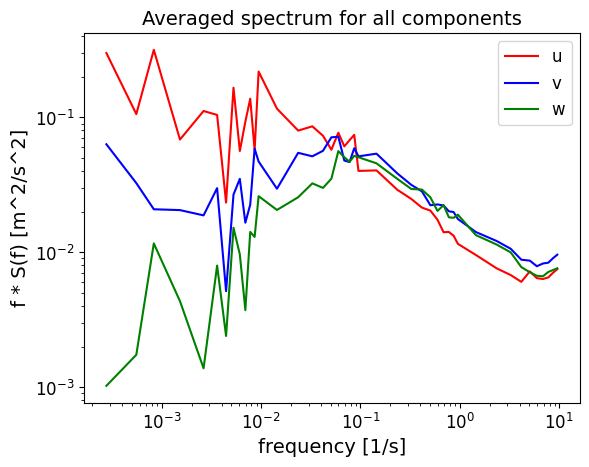

In [9]:
# QUESTION 1d version 2
#y = S * f

x_u, y_u = compute_rfftfreq(x_array=u_array-u_mean, N_tot=N_tot, K=1, fs=fs)
fS_u = compute_omega_S1(x_array=x_u, y_array=y_u, original_array=u_array, variance=True)
smoothx_u, smoothy_u = smoothering_filter(x_array=x_u, y_array=fS_u, num=10)

plt.figure(1)
plt.plot(x_u, fS_u, color='g', label='f*S1')
plt.plot(smoothx_u, smoothy_u, color='k', label='smooth')
plt_format_question1d('u')


x_v, y_v = compute_rfftfreq(x_array=v_array, N_tot=N_tot, K=1, fs=fs)
fS_v = compute_omega_S1(x_array=x_v, y_array=y_v, original_array=v_array, variance=True)
smoothx_v, smoothy_v = smoothering_filter(x_array=x_v, y_array=fS_v, num=10)

plt.figure(2)
plt.plot(x_v, fS_v, color='g', label='f*S')
plt.plot(smoothx_v, smoothy_v, color='k', label='smooth')
plt_format_question1d('w')


x_w, y_w = compute_rfftfreq(x_array=w_array, N_tot=N_tot, K=1, fs=fs)
fS_w = compute_omega_S1(x_array=x_w, y_array=y_w, original_array=w_array, variance=True)
smoothx_w, smoothy_w = smoothering_filter(x_array=x_w, y_array=fS_w, num=10)

plt.figure(3)
plt.plot(x_w, fS_w, color='g', label='f*S')
plt.plot(smoothx_w, smoothy_w, color='k', label='smooth')
plt_format_question1d('w')


plt.figure(4)
plt.plot(smoothx_u, smoothy_u, color='r', label='u')
plt.plot(smoothx_v, smoothy_v, color='b', label='v')
plt.plot(smoothx_w, smoothy_w, color='g', label='w')
plt_format_question1d_comparison()


plt.show()

law of -5/3 = -1.67
on S  : slope u = -1.62, v = -1.47, w = -1.51
intercept u = -4.39, v = -4.02, w = -4.05
intercept -4.154003541806027
on S  : alpha = 1.33 and Sv/Su = alpha1 = 1.39 and Sw/Su = alpha2 = 1.30


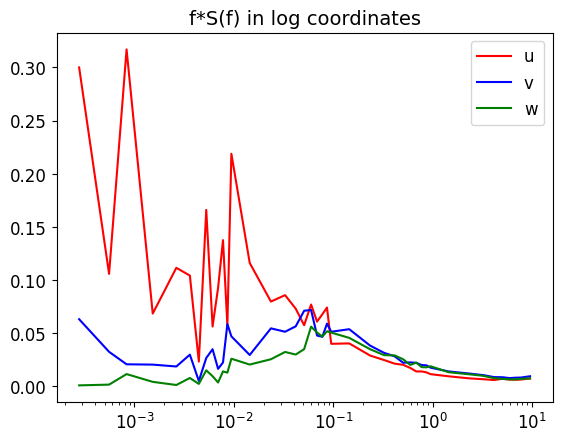

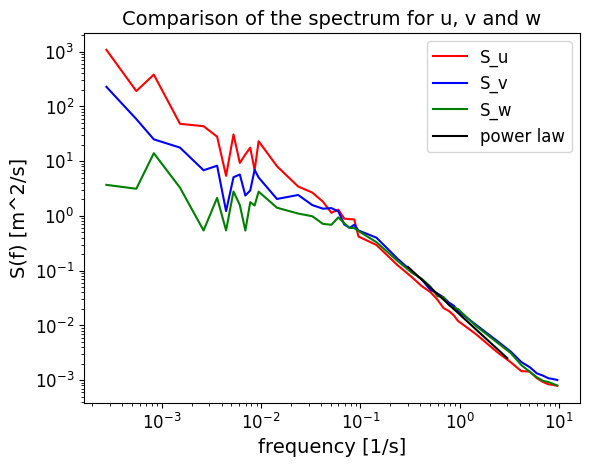

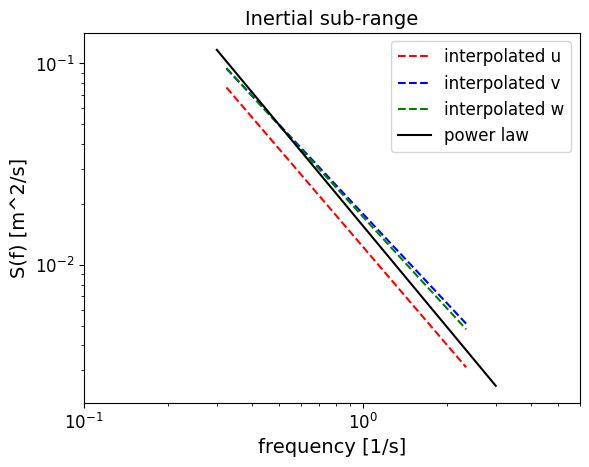

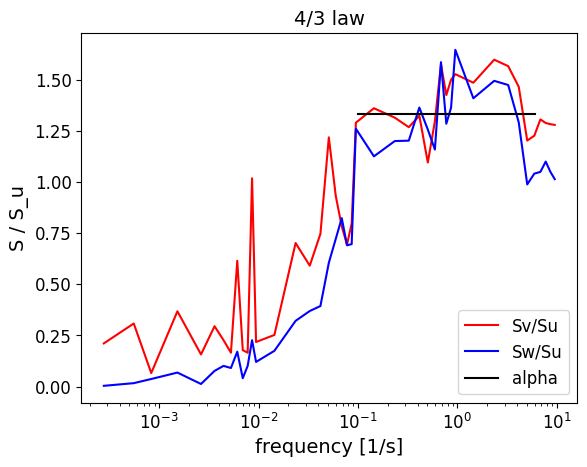

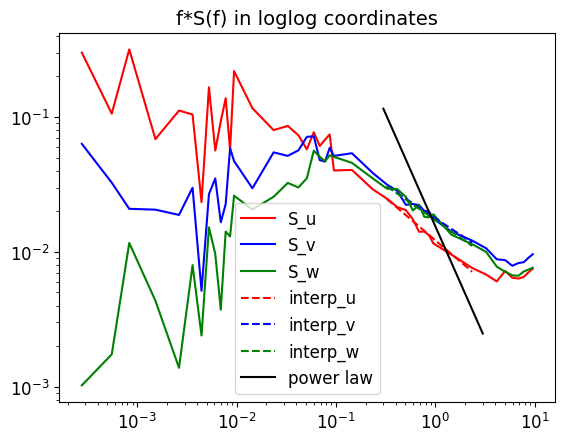

In [22]:
# QUESTION 1D law 5/3 and 4/3

x_u, y_u = compute_rfftfreq(x_array=u_array, N_tot=N_tot, K=1, fs=fs)
fS_u = compute_omega_S1(x_array=x_u, y_array=y_u, original_array=u_array, variance=False)
x_S_u, y_S_u = smoothering_filter(x_array=x_u, y_array=y_u, num=10)
x_fS_u, y_fS_u = smoothering_filter(x_array=x_u, y_array=fS_u, num=10)


x_v, y_v = compute_rfftfreq(x_array=v_array, N_tot=N_tot, K=1, fs=fs)
fS_v = compute_omega_S1(x_array=x_v, y_array=y_v, original_array=v_array, variance=False)
x_S_v, y_S_v = smoothering_filter(x_array=x_v, y_array=y_v, num=10)
x_fS_v, y_fS_v = smoothering_filter(x_array=x_v, y_array=fS_v, num=10)


x_w, y_w = compute_rfftfreq(x_array=w_array, N_tot=N_tot, K=1, fs=fs)
fS_w = compute_omega_S1(x_array=x_w, y_array=y_w, original_array=w_array, variance=False)
x_S_w, y_S_w = smoothering_filter(x_array=x_w, y_array=y_w, num=10)
x_fS_w, y_fS_w = smoothering_filter(x_array=x_w, y_array=fS_w, num=10)


plt.figure(1)
plt.title('f*S(f) in log coordinates')
plt.plot(x_fS_u, y_fS_u, color='r', label='u')
plt.plot(x_fS_v, y_fS_v, color='b', label='v')
plt.plot(x_fS_w, y_fS_w, color='g', label='w')
plt.xscale('log')
plt.legend()



exponent = -5/3
start = 0.3
stop = 3

slope1_u, intercept1_u, x_S_int_u, y_S_int_u,  = linear_regression_loglog(x_array=x_S_u, y_array=y_S_u, start=start, stop=stop)
slope1_v, intercept1_v, x_S_int_v, y_S_int_v,  = linear_regression_loglog(x_array=x_S_v, y_array=y_S_v, start=start, stop=stop)
slope1_w, intercept1_w, x_S_int_w, y_S_int_w,  = linear_regression_loglog(x_array=x_S_w, y_array=y_S_w, start=start, stop=stop)

slope2_u, intercept2_u, x_fS_int_u, y_fS_int_u,  = linear_regression_loglog(x_array=x_fS_u, y_array=y_fS_u, start=start, stop=3)
slope2_v, intercept2_v, x_fS_int_v, y_fS_int_v,  = linear_regression_loglog(x_array=x_fS_v, y_array=y_fS_v, start=start, stop=3)
slope2_w, intercept2_w, x_fS_int_w, y_fS_int_w,  = linear_regression_loglog(x_array=x_fS_w, y_array=y_fS_w, start=start, stop=3)

print(f'law of -5/3 = {exponent:.2f}')
print(f'on S  : slope u = {slope1_u:.2f}, v = {slope1_v:.2f}, w = {slope1_w:.2f}')
print(f'intercept u = {intercept1_u:.2f}, v = {intercept1_v:.2f}, w = {intercept1_w:.2f}')
#print(f'on f*S: slope u = {slope2_u:.2f}, v = {slope2_v:.2f}, w = {slope2_w:.2f}')


intercept_mean1 = np.mean([intercept1_u,intercept1_v, intercept1_w])
intercept_mean2 = np.mean([intercept2_u,intercept2_v, intercept2_w])

x_expected1, y_expected1 = power_law(slope=exponent, intercept=intercept_mean1, start=start, stop=stop)
x_expected2, y_expected2 = power_law(slope=exponent, intercept=intercept_mean2, start=start, stop=stop)
print('intercept',intercept_mean1)

alpha = 4/3
starta = 0.1
stopa = 6
alpha1, alpha2, ratio1, ratio2 = compute_ratios(x_array=x_S_u, Su=y_S_u, Sv=y_S_v, Sw=y_S_w, start=starta, stop=stopa)      
alphax = np.linspace(starta, stopa, num=100)
alphay =  np.full(len(alphax),alpha)

print(f'on S  : alpha = {alpha:.2f} and Sv/Su = alpha1 = {alpha1:.2f} and Sw/Su = alpha2 = {alpha2:.2f}')


plt.figure(2)
plt.title('Comparison of the spectrum for u, v and w')
plt.xlabel('frequency [1/s]')
plt.ylabel('S(f) [m^2/s]')
plt.plot(x_S_u, y_S_u, color='r', label='S_u')
plt.plot(x_S_v, y_S_v, color='b', label='S_v')
plt.plot(x_S_w, y_S_w, color='g', label='S_w')
plt.plot(x_expected1, y_expected1, color='k', label='power law')
plt.legend()

plt.xscale('log')
plt.yscale('log')


plt.figure(3)
plt.title('Inertial sub-range')
plt.xlabel('frequency [1/s]')
plt.ylabel('S(f) [m^2/s]')
plt.plot(x_S_int_u, y_S_int_u, color='r', linestyle='dashed', label='interpolated u')
plt.plot(x_S_int_v, y_S_int_v, color='b', linestyle='dashed', label='interpolated v')
plt.plot(x_S_int_w, y_S_int_w, color='g', linestyle='dashed', label='interpolated w')
plt.plot(x_expected1, y_expected1, color='k', label='power law')
plt.legend()

plt.xlim(0.1,6)
plt.xscale('log')
plt.yscale('log')


plt.figure(4)
plt.title('4/3 law')
plt.xlabel('frequency [1/s]')
plt.ylabel('S / S_u')
plt.plot(x_S_u, ratio1, color='r', label='Sv/Su')
plt.plot(x_S_u, ratio2, color='b', label='Sw/Su')
plt.plot(alphax, alphay, color='k', label='alpha')
#plt.axhline(y = alpha, xmin = 0.55, xmax=0.9, color='k', label='alpha') 

plt.legend(loc='lower right')
plt.xscale('log')
#plt.yscale('log')



plt.figure(5)
plt.title('f*S(f) in loglog coordinates')
plt.plot(x_fS_u, y_fS_u, color='r', label='S_u')
plt.plot(x_fS_v, y_fS_v, color='b', label='S_v')
plt.plot(x_fS_w, y_fS_w, color='g', label='S_w')
plt.plot(x_fS_int_u, y_fS_int_u, color='r', linestyle='dashed', label='interp_u')
plt.plot(x_fS_int_v, y_fS_int_v, color='b', linestyle='dashed', label='interp_v')
plt.plot(x_fS_int_w, y_fS_int_w, color='g', linestyle='dashed', label='interp_w')
plt.plot(x_expected2, y_expected2, color='k', label='power law')
plt.legend()

plt.xscale('log')
plt.yscale('log')


plt.show()


In [224]:
# SPROGO DATA

datas = pd.read_csv('sprog.tsv', delimiter='\t', header=None, 
                    names=['time','V','dir67', 'dir70'])
fss = 1/600

V_array_all = datas['V'].values
#check_compliant(V_array_all, 90)


V_array = []
for V in V_array_all:
    if V < 90:
        V_array.append(V)

N_tots = len(V_array)

1156277
1133028


time 679816800.0
variances of V_array = 15.27, computed with trapezoid = 15.27
in position 0: spectrum value = 0.72 for f = 0.0000032501 Hz hence T = 3.56 days
in position 1: spectrum value = 0.62 for f = 0.0000041504 Hz hence T = 2.79 days
in position 2: spectrum value = 0.62 for f = 0.0000023499 Hz hence T = 4.93 days
in position 3: spectrum value = 0.62 for f = 0.0000050506 Hz hence T = 2.29 days
in position 4: spectrum value = 0.52 for f = 0.0000000331 Hz hence T = 349.70 days


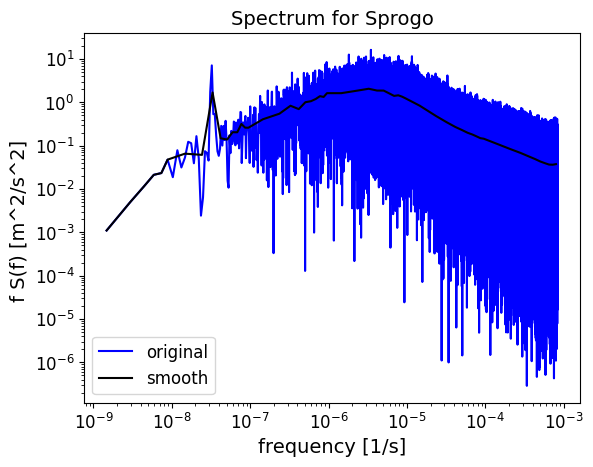

In [232]:
# QUESTION 2

x_V, y_V = compute_rfftfreq(x_array=V_array, N_tot=N_tots, K=1, fs=fss)
fS_V  = compute_omega_S1(x_array=x_V, y_array=y_V, original_array=V_array, variance=True)

smoothx_V, smoothy_V = smoothering_filter(x_array=x_V, y_array=Somega_V, num=10)

champions(smoothx_V, smoothy_V)


plt.figure(1)
plt.plot(x_V, Somega_V, color='b', label='original')
plt.plot(smoothx_V, smoothy_V, color='k', label='smooth')

plt.xlabel('frequency [1/s]')
plt.ylabel('f S(f) [m^2/s^2] ')
plt.legend(loc='lower left')
plt.title('Spectrum for Sprogo')

plt.xscale('log')
plt.yscale('log')



plt.show()

In [3]:
# QUESTION 4

z = 80
U = 70
u_stark = 0.25
Tk = 10*60
deltatk = 0.005
fsk = 1/deltatk

Nk = int(Tk/deltatk)
print(Nk)


120000


variances of series = 801.70786193, computed with trapezoid = 808.19126650


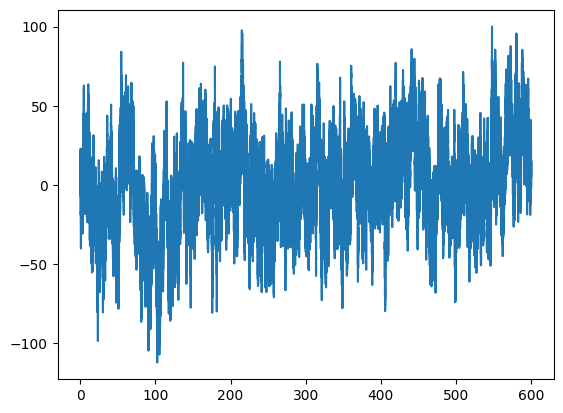

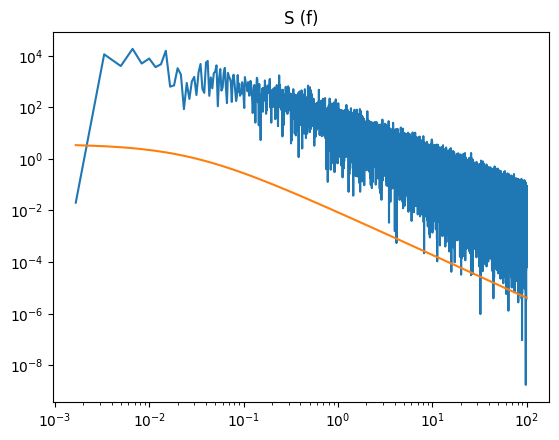

In [4]:
# version 1

f_half = rfftfreq(Nk, deltatk)
Sk = u_stark**2 * 52.5*z/U /(1 + 33*f_half*z/U)**(5/3)
f_half = f_half[1:]
Sk = Sk[1:]


X_l = np.random.normal(0, 1, size=int(Nk/2)) + 1j * np.random.normal(0, 1, size=int(Nk/2))

sigma = np.sqrt(Sk)*Tk
X = X_l*sigma
X0 = [2]
XNdiv2 = [2]
X = X[1:]


X_bar = np.concatenate((X0, X, XNdiv2, np.conjugate(X[::-1])))

series_image = ifft(X_bar)
series = np.real(series_image)*np.sqrt(len(series_image))
#series = np.abs(series_image)

t = []
for i in range(int(Nk)):
     t.append(i*deltatk)

plt.figure(1)
plt.plot(t, series)


y_series = rfft(series)
S_series = 1/(Nk*fsk)*np.abs(y_series)**2
S_half = S_series[:60000]


plt.figure(2)
plt.plot(f_half, S_half)
plt.plot(f_half, Sk)
plt.title('S (f)')
plt.yscale('log')
plt.xscale('log')

fs = compute_omega_S1(x_array=f_half, y_array=S_half, original_array=series, variance=True)


